# Third party scripts analysis

The analysis performed here is to measure how many of the scripts executed are from a third party domain.

e.g.<br> 
__location__: https://staticxx.facebook.com/connect/xd_arbit... 	
__script_url__: https://staticxx.facebook.com/connect/xd_arbit..
<br>In the above entry, both location and script_url are from the domain facebook.


But,<br>__location__:   cas.us.criteo.com 	
__script_url__: ajax.googleapis.com
<br>In this entry, location and script_url are from different domain. 


An inference is drawn at the end, dicussing the implications.

In [1]:
import dask.dataframe as dd
import pandas
from dask.distributed import Client

/home/shilpa/anaconda3/envs/overscripted/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/shilpa/anaconda3/envs/overscripted/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
client=Client()
client

/home/shilpa/anaconda3/envs/overscripted/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:35261 Dashboard: http://127.0.0.1:33141/status,Cluster Workers: 4 Cores: 12 Memory: 3.92 GB


In [3]:
import os
DATA_DIR = '/home/shilpa/work/overscripted/dataset'    

In [4]:
#sampleDataDir = os.path.join(DATA_DIR, 'sample/part-00000-34d9b361-ea79-42eb-82ee-9c9f9259c339-c000.snappy.parquet')
sampleDataDir = os.path.join(DATA_DIR, 'sample/')

In [5]:
pandas.set_option('display.max_columns', None)
#read the columns 'location' and 'script_url' only from the dataset
df_domain = dd.read_parquet(sampleDataDir, columns=['location', 'script_url'])
df_domain.head()

,location,script_url
0,https://staticxx.facebook.com/connect/xd_arbit...,https://staticxx.facebook.com/connect/xd_arbit...
1,https://staticxx.facebook.com/connect/xd_arbit...,https://staticxx.facebook.com/connect/xd_arbit...
2,https://staticxx.facebook.com/connect/xd_arbit...,https://staticxx.facebook.com/connect/xd_arbit...
3,https://staticxx.facebook.com/connect/xd_arbit...,https://staticxx.facebook.com/connect/xd_arbit...
4,https://cas.us.criteo.com/delivery/r/afr.php?d...,https://ajax.googleapis.com/ajax/libs/webfont/...


In [6]:
#Split the script_url field on the string '/' and index the 2nd element, to get the domain only from the whole URL
df_domain['script_url'] = df_domain['script_url'].str.split('/').str[2]

#Split the location field on the string '/' and index the 2nd element, to get the domain only from the whole URL
df_domain['location'] = df_domain['location'].str.split('/').str[2]

print('Listing the domain extractions from location and script_url field:', len(df_domain))
df_domain.head()

Listing the domain extractions from location and script_url field: 9234


,location,script_url
0,staticxx.facebook.com,staticxx.facebook.com
1,staticxx.facebook.com,staticxx.facebook.com
2,staticxx.facebook.com,staticxx.facebook.com
3,staticxx.facebook.com,staticxx.facebook.com
4,cas.us.criteo.com,ajax.googleapis.com


In [7]:
#Get rows where location domain and script_url domain are not the same.
#i.e., get the entries, where third party scripts are being executed

df_domain_diff = df_domain[df_domain['location'] != df_domain['script_url']]
print('Number of entries where location domain is not same as script_url:', len(df_domain_diff))
df_domain_diff.head()

Number of entries where location domain is not same as script_url: 7695


,location,script_url
4,cas.us.criteo.com,ajax.googleapis.com
5,pos.baidu.com,cpro.baidustatic.com
10,www.jumia.co.ke,static.dynamicyield.com
11,www.jumia.co.ke,static.dynamicyield.com
12,www.jumia.co.ke,static.dynamicyield.com


In [8]:
# Find the unique entries where location domain and corresponding script_url are not the same.
# i.e. drop duplicates from the dataframe where location domain and script_url are not the same
df_domain_diff_unique = df_domain_diff.drop_duplicates()
print('Number of unique entries where location domain is not same as script_url:', len(df_domain_diff_unique))
df_domain_diff_unique.head()

#In the above output, www.jumia.co.ke was showing up multiple times, accessing the url static.dynamicyield.com. 
# We reduce it to a single entry, here, in this cell output

Number of unique entries where location domain is not same as script_url: 304


,location,script_url
4,cas.us.criteo.com,ajax.googleapis.com
5,pos.baidu.com,cpro.baidustatic.com
10,www.jumia.co.ke,static.dynamicyield.com
34,www.syracuse.edu,www.googletagmanager.com
37,www.syracuse.edu,www.google-analytics.com


In [9]:
other_domain = len(df_domain['location'].drop_duplicates())
print('Total number of unique domain locations:', other_domain)

Total number of unique domain locations: 114


In [10]:
same_domain = len(df_domain_diff_unique['location'].drop_duplicates())
print('Total number of unique domain locations which are not accessing scripts from their own domain:', same_domain)

Total number of unique domain locations which are not accessing scripts from their own domain: 91


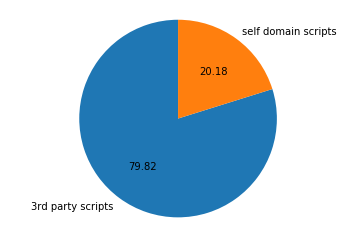

In [12]:
import matplotlib.pyplot as plotter
pieLabels = '3rd party scripts', 'self domain scripts'
pieShare = [same_domain, abs(other_domain - same_domain)]
figureObject, axesObject = plotter.subplots()

axesObject.pie(pieShare,
        labels=pieLabels,
        autopct='%1.2f',
        startangle=90)

axesObject.axis('equal')
plotter.show()

### Inference
Out of the total 114 unique domains in the dataset, 91 are calling scripts which is on a different domain.
For e.g. In the above output, cas.us.criteo.com is calling a script which resides at ajax.googleapis.com

From a end-user point of view, the user data is being captured by the domain at "location" and is also being passed to the domain "script_url". So the user data is not just being captured by one domain but is also being spread to another domain. Which implies, spread of user data.

From a technical perspective, why are few sites loading scripts from a third party domain?
(i) Are these third party domain scripts so technically superior?
                                  OR
(ii) For a Small and Medium Business(SMB) company, investing in developing tracking software is time-consuming or expensive and so they take the help of these third party script providers?
                                  OR
(iii) Is it a service like Ads and Analytics, for which a script located on a third party domain needs to be executed?

In any case, user data is spreading to more people.

p.s.: This has been run on a small sample dataset. Can be extended to the whole big dataset.